In [1]:
base_data = """date,delay,distance,origin,destination
02190925,1638,1846,SFO,ORD
01031755,396,733,JFK,LAX
01022330,326,993,BOS,DFW
01051205,320,1061,SEA,MIA
03041111,180,950,LAX,ORD
02071234,140,840,DFW,ATL
01111010,90,650,SEA,PHX
02231456,60,500,LAS,DEN
03061430,-20,300,SJC,OAK
01191225,-60,120,SNA,LAX
"""

with open("base_data.csv", "w") as f:
    f.write(base_data)

def make_file(name, copies):
    with open("base_data.csv", "r") as f:
        lines = f.readlines()

    header = lines[0]
    body = lines[1:] * copies

    with open(name, "w") as f:
        f.write(header)
        f.writelines(body)

make_file("data1.csv", 1)
make_file("data2.csv", 5)
make_file("data3.csv", 10)
make_file("data4.csv", 50)
make_file("data5.csv", 100)


In [2]:
!gsutil cp data1.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp data2.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp data3.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp data4.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp data5.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/

Copying file://data1.csv [Content-Type=text/csv]...
/ [1 files][  290.0 B/  290.0 B]                                                
Operation completed over 1 objects/290.0 B.                                      
Copying file://data2.csv [Content-Type=text/csv]...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      
Copying file://data3.csv [Content-Type=text/csv]...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      
Copying file://data4.csv [Content-Type=text/csv]...
/ [1 files][ 12.3 KiB/ 12.3 KiB]                                                
Operation completed over 1 objects/12.3 KiB.                                     
Copying file://data5.csv [Content-Type=text/csv]...
/ [1 files][ 24.6 KiB/ 24.6 KiB]                                                
Operati

In [3]:
from pyspark.sql import SparkSession
import time
import pandas as pd

spark = SparkSession.builder.appName("RuntimeTest").getOrCreate()

files = [
    "gs://dataproc-staging-us-central1-459220959832-gvez90q4/data1.csv",
    "gs://dataproc-staging-us-central1-459220959832-gvez90q4/data2.csv",
    "gs://dataproc-staging-us-central1-459220959832-gvez90q4/data3.csv",
    "gs://dataproc-staging-us-central1-459220959832-gvez90q4/data4.csv",
    "gs://dataproc-staging-us-central1-459220959832-gvez90q4/data5.csv"
]

results = []

for f in files:
    start = time.time()
    df = spark.read.csv(f, header=True, inferSchema=True)
    df.groupBy("origin").avg("delay").show()
    end = time.time()
    elapsed = end - start
    results.append((f, elapsed))
    print(f"{f}: {elapsed:.3f} seconds")

result_df = pd.DataFrame(results, columns=["filename", "runtime_sec"])
print(result_df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/12 04:30:57 INFO SparkEnv: Registering MapOutputTracker
25/04/12 04:30:58 INFO SparkEnv: Registering BlockManagerMaster
25/04/12 04:30:58 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/12 04:30:58 INFO SparkEnv: Registering OutputCommitCoordinator


+------+----------+
|origin|avg(delay)|
+------+----------+
|   SFO|    1638.0|
|   SNA|     -60.0|
|   SJC|     -20.0|
|   BOS|     326.0|
|   JFK|     396.0|
|   LAS|      60.0|
|   LAX|     180.0|
|   SEA|     205.0|
|   DFW|     140.0|
+------+----------+

gs://dataproc-staging-us-central1-459220959832-gvez90q4/data1.csv: 14.148 seconds


+------+----------+
|origin|avg(delay)|
+------+----------+
|   SFO|    1638.0|
|   SNA|     -60.0|
|   SJC|     -20.0|
|   BOS|     326.0|
|   JFK|     396.0|
|   LAS|      60.0|
|   LAX|     180.0|
|   SEA|     205.0|
|   DFW|     140.0|
+------+----------+

gs://dataproc-staging-us-central1-459220959832-gvez90q4/data2.csv: 3.062 seconds
+------+----------+
|origin|avg(delay)|
+------+----------+
|   SFO|    1638.0|
|   SNA|     -60.0|
|   SJC|     -20.0|
|   BOS|     326.0|
|   JFK|     396.0|
|   LAS|      60.0|
|   LAX|     180.0|
|   SEA|     205.0|
|   DFW|     140.0|
+------+----------+

gs://dataproc-staging-us-central1-459220959832-gvez90q4/data3.csv: 1.482 seconds
+------+----------+
|origin|avg(delay)|
+------+----------+
|   SFO|    1638.0|
|   SNA|     -60.0|
|   SJC|     -20.0|
|   BOS|     326.0|
|   JFK|     396.0|
|   LAS|      60.0|
|   LAX|     180.0|
|   SEA|     205.0|
|   DFW|     140.0|
+------+----------+

gs://dataproc-staging-us-central1-459220959832-gvez90q4

In [4]:
import subprocess

file_sizes = []
for f in files:
    cmd = f"gsutil du {f}"
    output = subprocess.check_output(cmd, shell=True).decode("utf-8")
    size_in_bytes = int(output.split()[0])
    file_sizes.append(size_in_bytes / 1024)

# Add to the result dataframe
result_df["file_size_kb"] = file_sizes
print(result_df)

                                            filename  runtime_sec  \
0  gs://dataproc-staging-us-central1-459220959832...    14.148416   
1  gs://dataproc-staging-us-central1-459220959832...     3.061777   
2  gs://dataproc-staging-us-central1-459220959832...     1.481615   
3  gs://dataproc-staging-us-central1-459220959832...     1.632324   
4  gs://dataproc-staging-us-central1-459220959832...     1.414020   

   file_size_kb  
0      0.283203  
1      1.263672  
2      2.489258  
3     12.293945  
4     24.549805  


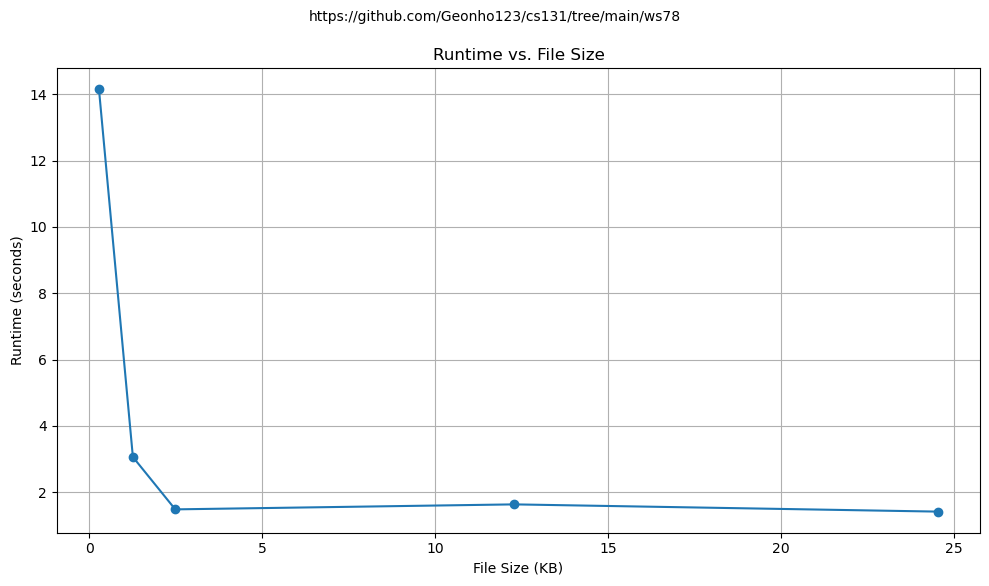

In [5]:
import matplotlib.pyplot as plt

sizes = result_df["file_size_kb"]
times = result_df["runtime_sec"]

plt.figure(figsize=(10, 6))
plt.figtext(0.5, 0.95, "https://github.com/Geonho123/cs131/tree/main/ws78", ha="center", fontsize=10)

plt.plot(sizes, times, marker='o')
plt.title("Runtime vs. File Size")
plt.xlabel("File Size (KB)")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.savefig("ws78.pdf")
plt.show()


In [6]:
# Read data5.csv
with open("data5.csv", "r") as f:
    lines = f.readlines()

# Take the first 10 lines
sample_lines = lines[:10]

# Write to data_sample.csv
with open("data_sample.csv", "w") as f:
    f.writelines(sample_lines)

In [7]:
!gsutil cp data_sample.csv gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp ws78.pdf gs://dataproc-staging-us-central1-459220959832-gvez90q4/
!gsutil cp ws78.ipynb gs://dataproc-staging-us-central1-459220959832-gvez90q4/

Copying file://data_sample.csv [Content-Type=text/csv]...
/ [1 files][  265.0 B/  265.0 B]                                                
Operation completed over 1 objects/265.0 B.                                      
Copying file://ws78.pdf [Content-Type=application/pdf]...
/ [1 files][ 16.0 KiB/ 16.0 KiB]                                                
Operation completed over 1 objects/16.0 KiB.                                     
Copying file://ws78.ipynb [Content-Type=application/octet-stream]...
/ [1 files][ 45.2 KiB/ 45.2 KiB]                                                
Operation completed over 1 objects/45.2 KiB.                                     


In [8]:
!gsutil cp gs://dataproc-staging-us-central1-459220959832-gvez90q4/data_sample.csv .
!gsutil cp gs://dataproc-staging-us-central1-459220959832-gvez90q4/ws78.pdf .
!gsutil cp gs://dataproc-staging-us-central1-459220959832-gvez90q4/ws78.ipynb .

Copying gs://dataproc-staging-us-central1-459220959832-gvez90q4/data_sample.csv...
/ [1 files][  265.0 B/  265.0 B]                                                
Operation completed over 1 objects/265.0 B.                                      
Copying gs://dataproc-staging-us-central1-459220959832-gvez90q4/ws78.pdf...
/ [1 files][ 16.0 KiB/ 16.0 KiB]                                                
Operation completed over 1 objects/16.0 KiB.                                     
Copying gs://dataproc-staging-us-central1-459220959832-gvez90q4/ws78.ipynb...
/ [1 files][ 45.2 KiB/ 45.2 KiB]                                                
Operation completed over 1 objects/45.2 KiB.                                     
